In [46]:
import os 
import sys

import numpy as np

from tqdm import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor

import re

import matplotlib.pyplot as plt

sys.path.append(os.getcwd())
sys.path.insert(0, "../porousequivariantnetworks/code/")
sys.path.insert(0, "../porousequivariantnetworks/")

from models.equivariant_mpnn import MPNNPORE

from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [47]:
hoa = np.load('C:/users/20175552/Code/zeolite-property-prediction/Data/MOR/hoa.npy')
henry = np.load('C:/users/20175552/Code/zeolite-property-prediction/Data/MOR/henry.npy')
ats_old = np.load('C:/users/20175552/Code/zeolite-property-prediction/Data/MOR/atoms.npy')

In [3]:
hoa.shape, henry.shape, ats_old.shape

((5011,), (5011,), (5011, 48))

In [4]:
data = get_zeolite('MOR')

ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
_, _, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l)

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)


In [5]:
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)


In [6]:
def get_ats(idx):
    with open(f'Data_isotherms/isomors/MOR_{idx}.cif') as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = [1 if i[0]=='Al' else 0 for i in at_pos]
    return atom

def get_iso(idx):
    with open(f'Data_isotherms/curves/plot_data_{idx}') as f:
        lines = f.read()
        #p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?)', lines)
        p = re.findall(r'p\[(?:[1-6])\]=(-?\d+(?:\.\d+)?(?:e[+-]?\d+)?)', lines)

    p = [float(i) for i in p]
    x = 10**np.arange(1,7,0.01)
    true_p = langmuirfreudlich(np.array(p)[None], x)

    return p

def langmuirfreudlich(p, x):
    return p[:,0]*p[:,1]*x**p[:,2]/(1.0+p[:,1]*x**p[:,2])+p[:,3]*p[:,4]*x**p[:,5]/(1.0+p[:,4]*x**p[:,5])
    

In [148]:
n = 5012

atoms = np.zeros((n, 48))
iso_params = np.zeros((n, 6))


for zeo in tqdm(range(n)):

    atoms[zeo] = get_ats(zeo)
    iso_params[zeo] = get_iso(zeo)

100%|██████████████████████████████████████████████████████████████████████████████| 5012/5012 [01:17<00:00, 64.48it/s]


In [149]:



u_atoms = np.unique(ats_old, axis=0)
n = len(u_atoms)

iso_params1 = np.zeros((n,6))
hoa1 = np.zeros((n,))
henry1 = np.zeros((n,))

for i in range(n):
    mask1 = (u_atoms[i] == atoms).all(-1)
    
    # if mask1.sum() > 1:
    #     print(iso_params[mask1], i)
    #     print('----------------------')
    iso_params1[i] = iso_params[mask1][0]

    mask2 = (u_atoms[i] == ats_old).all(-1)

    if mask2.sum() < 1:
        print(i)#hoa[mask2], henry[mask2], i)

    hoa1[i] = np.mean(hoa[mask2])
    henry1[i] = np.log10(np.mean(henry[mask2]))

In [58]:
henry1.min(), henry1.max()

(-4.9979808885985335, -1.9526472392460659)

In [59]:
iso_params1.shape, hoa1.shape, henry1.shape

((4789, 6), (4789,), (4789,))

In [60]:
data_y = np.concatenate([iso_params1,hoa1[:,None],henry1[:,None]], 1)

In [61]:
#np.isnan(a).sum()

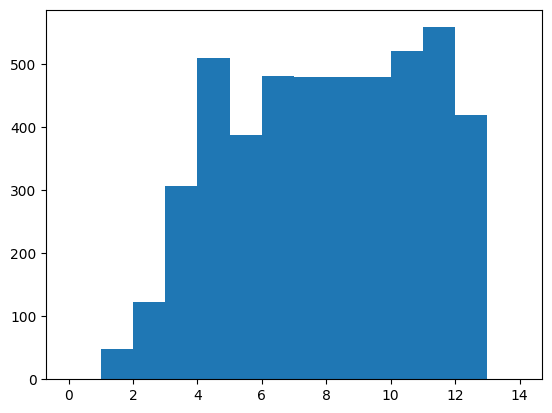

In [62]:
plt.hist(u_atoms.sum(1), bins=np.arange(0, 15));

In [63]:
def get_pred_points(steps):

    return 10**np.arange(1,7+1/steps,1/steps)
    

In [274]:
class calculate_distance(nn.Module):

    def __init__(self, pred_points):
        super().__init__()

        self.points = torch.tensor(pred_points)[:, None].to('cuda')#torch.tensor(10**np.arange(1,7+6/n_points,6/n_points))[:, None]
        self.n_points = pred_points.shape[0]
        
    def forward(self, p_hat, param_p):
        # add channels dimension
        #param_p_hat = param_p_hat[:,None]

        
        #p_hat = F.interpolate(param_p_hat, self.n_points+1, align_corners=True, mode='linear').squeeze()
        points = self.points.repeat(1, p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        #loss = ((p_hat - p)**2).mean(1)
        loss = ((p_hat - p).abs()).mean(1)
        return loss


class calculate_distance_points(nn.Module):

    def __init__(self, pred_points, mode='mae'):
        super().__init__()
        assert mode in ['mae','mse']
        self.mode = mode
        self.points = torch.tensor(pred_points)[:,None]
        
    def forward(self, param_p_hat, param_p):
        points = self.points.repeat(1, param_p_hat.shape[0]).to('cuda')
        p = langmuirfreudlich(param_p, points).T

        if self.mode == 'mse':
            loss = ((param_p_hat - p)**2).mean(1)
        elif self.mode == 'mae':
            loss = ((param_p_hat - p).abs()).mean(1)
        return loss
        

        
    

In [323]:
_, testloader, trainloader = get_data_pore(u_atoms, data_y, edges, pore, edges_sp, edges_ps, bs=32,random=True, p=1, test_size=0.08,drop_last=True)

Text(0, 0.5, 'Loading (mol/kg)')

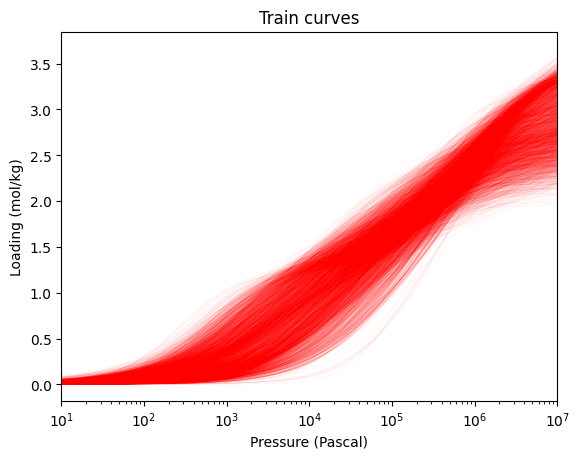

In [324]:
x = 10**np.arange(1,7.01,0.01)
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy()[:,:-2], x)
    plt.plot(x, true_p, alpha = .1, lw=.2, c='r')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Train curves')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

Text(0, 0.5, 'Loading (mol/kg)')

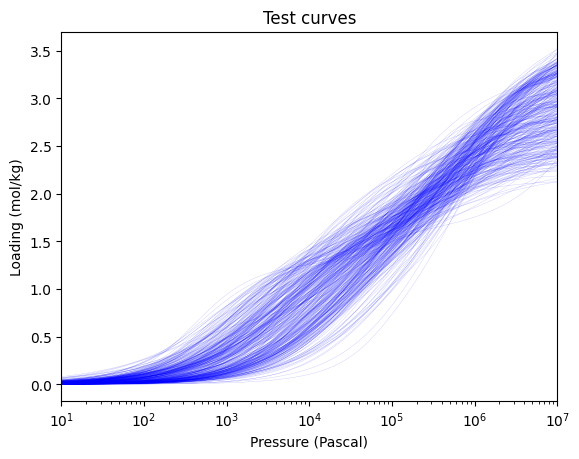

In [325]:
x = 10**np.arange(1,7.01,0.01)
for i in range(len(testloader.dataset)):
    true_p = langmuirfreudlich(testloader.dataset.y[[i]].numpy()[:,:-2], x)
    plt.plot(x, true_p, alpha = .3, lw=.2, c='b')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Test curves')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

In [326]:
pred_points = get_pred_points(3)

In [327]:
baseline_preds = np.zeros((pred_points.shape[0],))
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy()[:,:-2], pred_points)
    baseline_preds += true_p
baseline_preds /= len(trainloader.dataset)

In [328]:
errors = []
for i in range(len(testloader.dataset)):

    errors.append(calculate_distance_points(pred_points)(torch.tensor(baseline_preds)[None].cuda(), testloader.dataset.y[[i]].cuda()[:,:-2]).item())

In [329]:
print('baseline:', np.mean(errors))

baseline: 0.1573496586618149


Text(0, 0.5, 'Loading (mol/kg)')

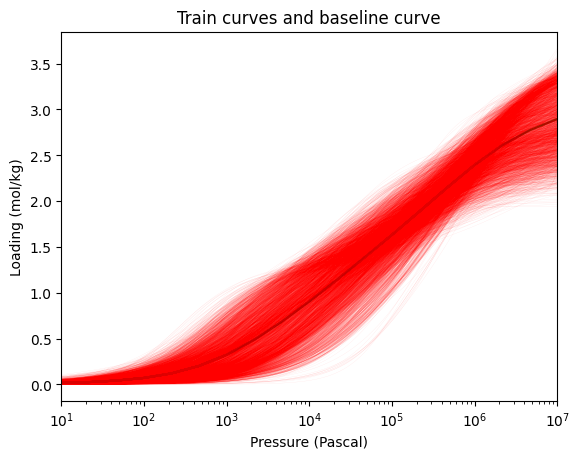

In [330]:
plt.plot(pred_points, baseline_preds, c='g')
x = 10**np.arange(1,7.01,0.01)
for i in range(len(trainloader.dataset)):
    true_p = langmuirfreudlich(trainloader.dataset.y[[i]].numpy(), x)
    plt.plot(x, true_p, alpha = .1, lw=.2, c='r')
plt.xscale('log')
plt.xlim(10, 1e7)
plt.title('Train curves and baseline curve')
plt.xlabel('Pressure (Pascal)')
plt.ylabel('Loading (mol/kg)')

In [331]:
len(pred_points), np.log10(pred_points)

(19,
 array([1.        , 1.33333333, 1.66666667, 2.        , 2.33333333,
        2.66666667, 3.        , 3.33333333, 3.66666667, 4.        ,
        4.33333333, 4.66666667, 5.        , 5.33333333, 5.66666667,
        6.        , 6.33333333, 6.66666667, 7.        ]))

In [332]:
h_size = 12

In [333]:
class Gaussian(nn.Module):
    
    def __init__(self):
        
        super().__init__()
    
    def forward(self, x):
        
        return (-x.pow(2)).exp()

class GaussianSmearing(nn.Module):
    def __init__(
        self,
        start: float = 0.0,
        stop: float = 10.0,
        num_gaussians: int = 50,
    ):
        super().__init__()
        offset = torch.linspace(start, stop, num_gaussians)
        self.coeff = -0.5 / (offset[1] - offset[0]).item()**2
        self.register_buffer('offset', offset)

    def forward(self, dist: Tensor) -> Tensor:
        dist = dist.view(-1, 1) - self.offset.view(1, -1)
        return torch.exp(self.coeff * torch.pow(dist, 2))

In [419]:
class PoreLoading(nn.Module):

    def __init__(self, pred_points, out_size=32, f_layer_1 = 2, f_layer_2 = 1, gaussian_p_size=16):
        super().__init__()

        self.pred_points = torch.tensor(pred_points).to('cuda').float()
        self.mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=8,
                centers=12, mx_d=8, width=1, pool='sum', pool_pore=True, site_pred=True,
                out_size=out_size).to('cuda')
        
        
        self.p_emb = GaussianSmearing(num_gaussians=gaussian_p_size)
        self.lin_p = nn.Linear(gaussian_p_size, out_size)
        
        self.lin_1 = nn.Sequential(nn.Linear(out_size, f_layer_1))

        self.lin_2_0 = nn.Sequential(nn.Linear(out_size, out_size), nn.SiLU(),nn.Linear(out_size, out_size), nn.SiLU())
        self.lin_2_1 = nn.Sequential(nn.Linear(f_layer_1, out_size), nn.SiLU(),nn.Linear(out_size, out_size), nn.SiLU())

        self.lin_2 = nn.Sequential(nn.Linear(3*out_size, out_size), nn.SiLU(), nn.Linear(out_size, out_size), nn.SiLU(), nn.Linear(out_size, 1))
        
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.silu = nn.SiLU()

        
    def forward(self, sites, bonds, sites_p, bonds_sp, bonds_ps, true_1=None, pred_points=None):

        if pred_points is None:
            pred_points = self.pred_points
        
        h1 = self.silu(self.mpnn(sites, bonds, sites_p, bonds_sp, bonds_ps))
        
        pred_1 = self.lin_1(h1).sum(1)
        
        out_1 = pred_1 if true_1 is None else true_1

        h_0 = self.lin_2_0(h1.sum(1)) # embed final hidden state (n, h)
        h_1 = self.lin_2_1(out_1) # embed DNA layer 1 predictions (n, h)
        h_2 = self.lin_p(self.p_emb(torch.log10(pred_points))) # Embed pressures (p, h)

        h_0 = h_0[:,None].repeat(1, h_2.shape[0], 1)
        h_1 = h_1[:,None].repeat(1, h_2.shape[0], 1)
        h_2 = h_2[None].repeat(h_0.shape[0], 1, 1)

        h2 = torch.cat([h_0, h_1, h_2], -1)

        pred_2 = self.lin_2(h2).squeeze(-1)

        return pred_1, pred_2
        
    def fit(self, trainloader, testloader, epochs, crit=nn.MSELoss, crit_kwargs={}, opt=optim.Adam, opt_kwargs={'lr':0.001}, alpha_start=1, alpha_end=0, alpha_epochs=20):
        
        # defines optimizer + loss criterion
        self.optimizer = opt(params=self.parameters(), **opt_kwargs)
        self.criterion = crit(**crit_kwargs)
        
        train_loss = []
        test_loss = []
        
        pbar = tqdm(range(epochs), unit='epoch', postfix='loss', position=0, leave=True)
        for e in pbar:
            
            alpha = alpha_start + min(e/alpha_epochs, 1)*(alpha_end-alpha_start)
            
            self.train()
            for idx, (sites, bonds, sites_p, bonds_sp, bonds_ps, y) in enumerate(trainloader):
                
                # model breaks for batch size 1
                if sites.shape[0] == 1:
                    continue
                    
                self.optimizer.zero_grad()
                sites, bonds, sites_p, bonds_sp, bonds_ps, y = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda'), y.float().to('cuda')
                
                y2 = y[:,:-2]
                y1 = y[:,-2:]

                true_1 = None if np.random.rand() > alpha else y1
                
                y1_hat, y2_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, true_1)
                
                loss1 = F.huber_loss(y1_hat, y1, 'none', 0.5).sum(-1).mean()
                loss2 = self.criterion(y2_hat, y2).mean()

                loss = loss1 + 25*loss2
                loss = loss.mean()
                loss.backward()
                self.optimizer.step()

                train_loss.append(loss.item())

        
            self.eval()

            for idx, (sites, bonds, sites_p, bonds_sp, bonds_ps, y) in enumerate(testloader):
                
                
                # model breaks for batch size 1
                if sites.shape[0] == 1:
                    continue
                
                with torch.no_grad():
                    sites, bonds, sites_p, bonds_sp, bonds_ps, y = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda'), y.float().to('cuda')

                    y2 = y[:,:-2]
                    y1 = y[:,-2:]

                    true_1 = None if np.random.rand() > alpha else y1
                    
                    y1_hat, y2_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, true_1)
                    
                    loss1 = F.huber_loss(y1_hat, y1, 'none', 0.5).sum(-1).mean()
                    loss2 = self.criterion(y2_hat, y2).mean()
    
                    loss = loss1 + 25*loss2
                
                    loss = loss.mean()
                    test_loss.append(loss.item())
            pbar.postfix = f'loss: {np.mean(train_loss[-len(trainloader)+1:]):.3f} test loss: {np.mean(test_loss[-len(testloader)+1:]):.3f}'

        return train_loss, test_loss


    @torch.no_grad
    def predict(self, dataloader, pred_points):

        n = len(dataloader.dataset)
    
        props_pred = np.zeros((n, 2))
        isotm_pred = np.zeros((n, len(pred_points)))
    
        props_true = np.zeros((n, 2))
        isotm_true = np.zeros((n, len(pred_points)))
        
        bs = dataloader.batch_size
        for idx, batch in enumerate(dataloader):
    
            
            
            sites, bonds, sites_p, bonds_sp, bonds_ps, y = batch
            sites, bonds, sites_p, bonds_sp, bonds_ps = sites.float().to('cuda'), bonds.float().to('cuda'), sites_p.float().to('cuda'), bonds_sp.float().to('cuda'), bonds_ps.float().to('cuda')
            _bs = len(sites)
            y2 = y[:,:-2]
            y1 = y[:,-2:]
    
            p_true = langmuirfreudlich(y2, pred_points[:,None].repeat(1, _bs).cpu()).T
    
            
            y1_hat, y2_hat = self.forward(sites, bonds, sites_p, bonds_sp, bonds_ps, pred_points=pred_points)
    
            props_pred[bs*idx:bs*idx+_bs] = y1_hat.cpu().numpy()
            isotm_pred[bs*idx:bs*idx+_bs] = y2_hat.cpu().numpy()
    
            props_true[bs*idx:bs*idx+_bs] = y1.numpy()
            isotm_true[bs*idx:bs*idx+_bs] = p_true
    
        return props_pred, isotm_pred, props_true, isotm_true


In [457]:
mpnn = PoreLoading(pred_points).to('cuda')


In [458]:
tr_loss, te_loss = mpnn.fit(trainloader, testloader, epochs=150, crit=calculate_distance_points, crit_kwargs={'pred_points':pred_points,'mode':'mse'}, opt=optim.Adam, opt_kwargs={'lr':0.001})

100%|█████████████████████████████████████████████| 150/150 [1:11:34<00:00, 28.63s/epoch, loss: 0.531 test loss: 0.609]


(0.0, 10.0)

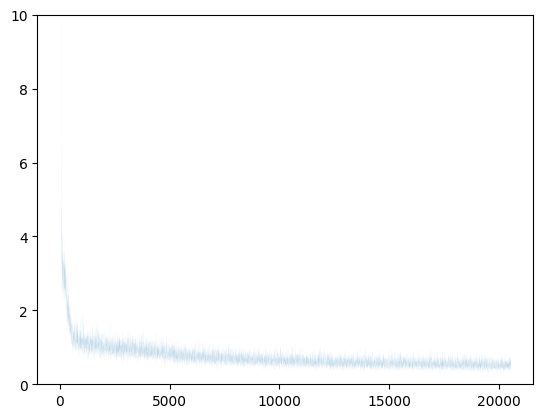

In [459]:
plt.plot(tr_loss, lw=0.01)
plt.ylim(0, 10)

In [460]:
def plot_all_pred(mpnn, dataloader, pred_points):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4))

    for idx in range(len(dataloader.dataset)):
        atoms = dataloader.dataset.X[[idx]]
        iso_params = dataloader.dataset.y[[idx]][:,:-2]
        atoms = atoms.cuda().float()
        iso_params = iso_params.numpy()


        
        x = 10**np.arange(1,7.01,0.01)
        true_p = langmuirfreudlich(iso_params, x)
        ax[1].plot(x, true_p, c='r', lw=.2, alpha=.75)

        with torch.no_grad():
            mpnn.eval()
            p_hat = mpnn.forward(atoms.repeat(2,1,1), edges.cuda()[None].repeat(2,1,1), torch.tensor(pore).cuda().float()[None].repeat(2,1,1), edges_sp.cuda()[None].repeat(2,1,1), edges_ps.cuda()[None].repeat(2,1,1))[1][0].cpu()

        ax[0].plot(pred_points, p_hat, c='b', lw=.2, alpha=.75)
        
    ax[0].set_ylim( 0,4)
    ax[0].set_xscale('log')
    ax[1].set_ylim( 0,4)
    ax[1].set_xscale('log')
    ax[0].set_title('Predicted Isotherms')
    ax[1].set_title('True Isotherms')
    ax[0].set_xlim(x[0], x[-1])
    ax[1].set_xlim(x[0], x[-1])
    ax[0].set_ylabel('Pressure (Pa)')
    ax[0].set_xlabel('Loading (mol/kg)')
    ax[1].set_ylabel('Pressure (Pa)')
    ax[1].set_xlabel('Loading (mol/kg)')
    #ax[0].vlines(pred_points, ymin=0, ymax=4, ls='--', lw=.2)
    return fig, ax


def plot_true_pred(mpnn, dataloader, idx, pred_points, fig=None, ax=None, cumsum=False, relu=False):

    atoms = dataloader.dataset.X[[idx]]
    _iso_params = dataloader.dataset.y[[idx]][:,:-2]
    atoms = atoms.cuda().float()
    _iso_params = _iso_params.numpy()
    
    idx = np.where((iso_params == _iso_params).all(1))[0]


    if fig is None:
        fig, ax = plt.subplots()

    x = 10**np.arange(1,7.01,0.01)
    true_p = langmuirfreudlich(_iso_params, x)
    ax.plot(x, true_p, label='fitted isotherm')

    with torch.no_grad():
        mpnn.eval()
        p_hat = mpnn.forward(atoms.repeat(2,1,1), edges.cuda()[None].repeat(2,1,1), torch.tensor(pore).cuda().float()[None].repeat(2,1,1), edges_sp.cuda()[None].repeat(2,1,1), edges_ps.cuda()[None].repeat(2,1,1))[1][0].cpu()
    #print(p_hat)
    ax.plot(pred_points, p_hat, label='predicted isotherm')
    ax.set_ylim(0,4)
    ax.set_xlim(x[0], x[-1])
    ax.set_xscale('log')
    ax.vlines(pred_points, ymin=0, ymax=4, ls='--', lw=.2)
    ax.set_xlabel('Pressure (Pa)')
    ax.set_ylabel('Loading (mol/kg)')
    
    raw_p = np.array([1e1,1e2,3e2,1e3,3e3,1e4,3e4,1e5,3e5,1e6,3e6,1e7])
    ax.scatter(raw_p, raw_data[idx], label='raw data')
    plt.legend()
    return fig, ax

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: title={'center': 'Predicted Isotherms'}, xlabel='Loading (mol/kg)', ylabel='Pressure (Pa)'>,
        <Axes: title={'center': 'True Isotherms'}, xlabel='Loading (mol/kg)', ylabel='Pressure (Pa)'>],
       dtype=object))

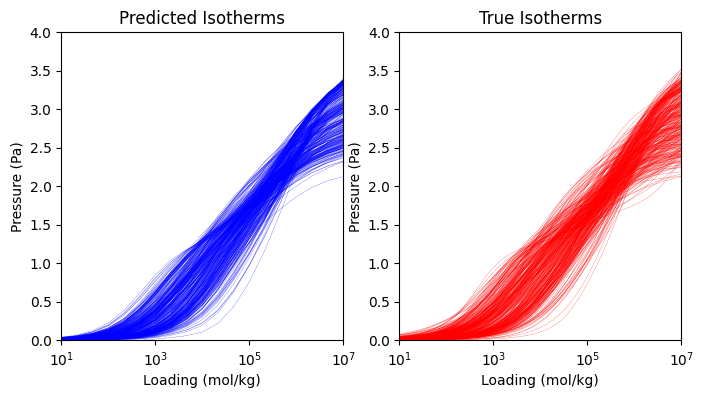

In [461]:
plot_all_pred(mpnn, testloader, pred_points)

In [462]:
raw_data = np.load('raw_data.npy')

In [463]:
raw_data.shape

(5012, 12)

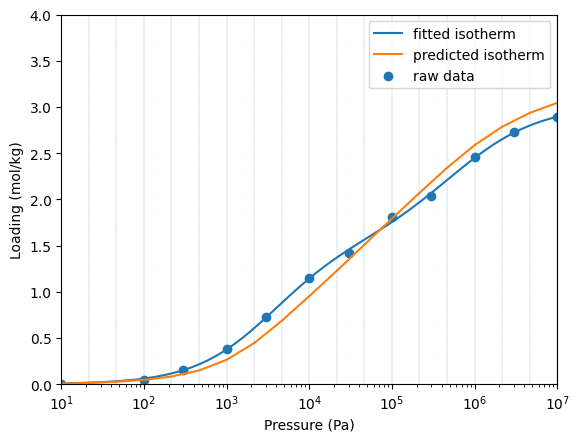

In [464]:
f,a = plot_true_pred(mpnn, testloader, np.random.choice(np.arange(len(testloader.dataset))), pred_points, cumsum=False, relu=False)

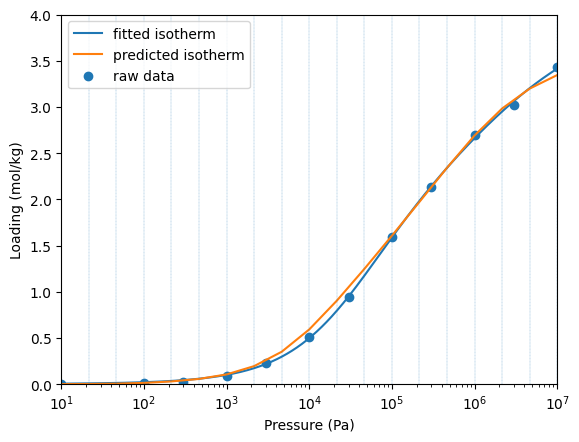

In [465]:
f,a = plot_true_pred(mpnn, testloader, np.random.choice(np.arange(len(testloader.dataset))), pred_points, cumsum=False, relu=False)

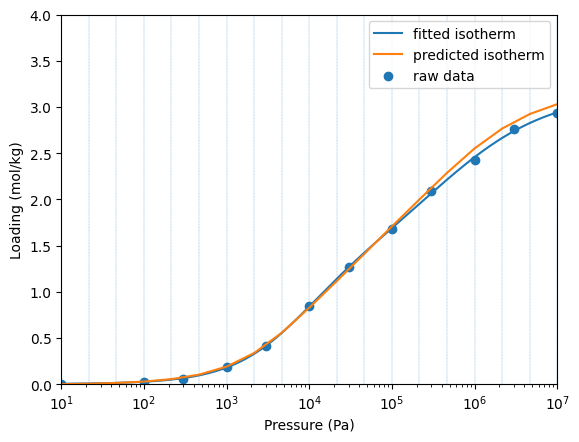

In [466]:
f,a = plot_true_pred(mpnn, testloader, 5, pred_points, cumsum=False, relu=False)

In [467]:
len(testloader.dataset)

384

In [468]:
bad = [368,394,330,136]

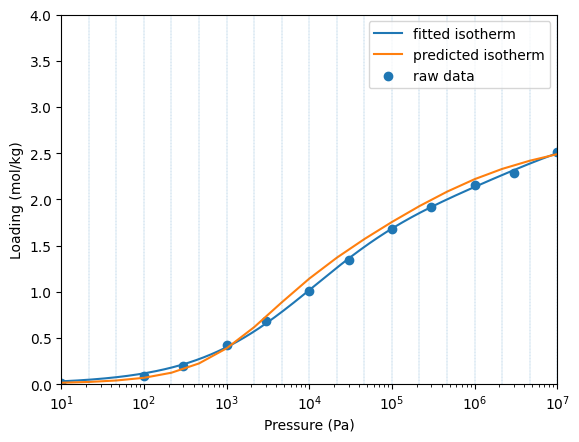

In [469]:
f,a = plot_true_pred(mpnn, testloader, 354, pred_points, cumsum=False, relu=False)

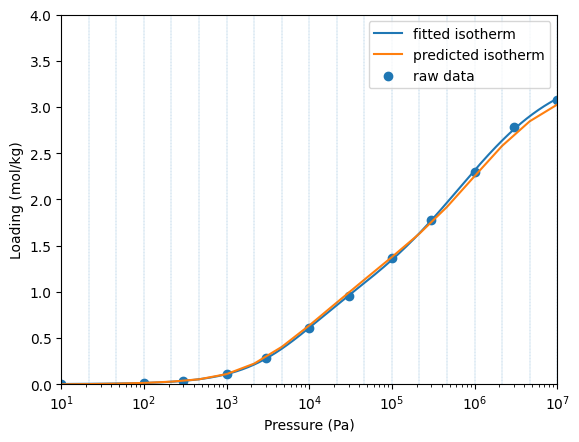

In [470]:
f,a = plot_true_pred(mpnn, testloader, 330, pred_points, cumsum=False, relu=False)

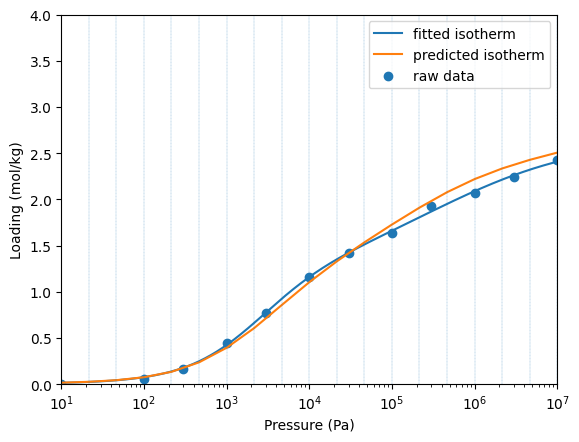

In [471]:
f,a = plot_true_pred(mpnn, testloader, 136, pred_points, cumsum=False, relu=False)

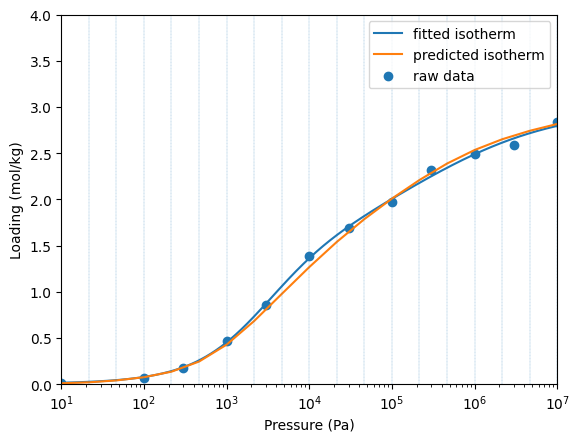

In [472]:
f,a = plot_true_pred(mpnn, testloader, 69, pred_points, cumsum=False, relu=False)

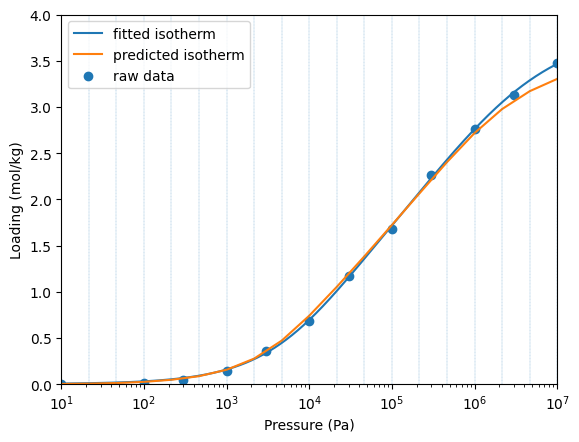

In [473]:
f,a = plot_true_pred(mpnn, testloader, 42, pred_points, cumsum=False, relu=False)

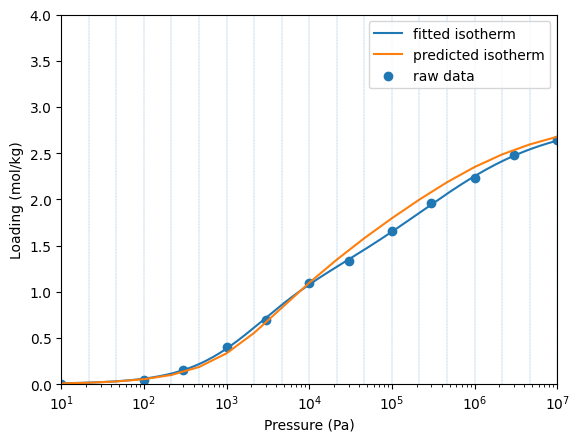

In [474]:
f,a = plot_true_pred(mpnn, testloader, 2, pred_points, cumsum=False, relu=False)

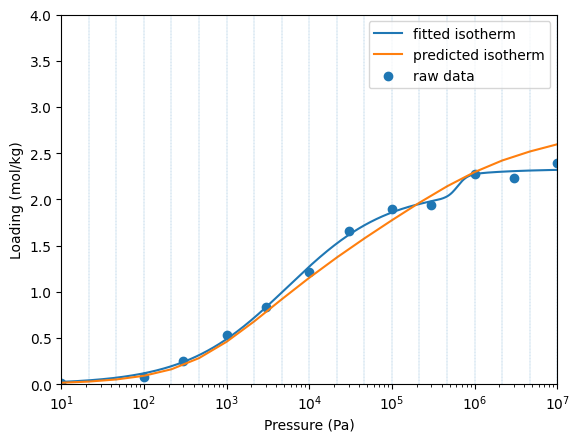

In [475]:
f,a = plot_true_pred(mpnn, testloader, 3, pred_points, cumsum=False, relu=False)

In [487]:
pp,ip,pt,it = mpnn.predict(testloa, torch.tensor(get_pred_points(20)).cuda().float())

(array([2.000e+00, 1.000e+00, 1.500e+01, 6.900e+01, 4.380e+02, 2.293e+03,
        1.430e+03, 1.410e+02, 6.000e+00, 1.000e+01]),
 array([-10.43121879,  -8.734455  ,  -7.03769122,  -5.34092743,
         -3.64416365,  -1.94739986,  -0.25063608,   1.44612771,
          3.14289149,   4.83965528,   6.53641906]),
 <BarContainer object of 10 artists>)

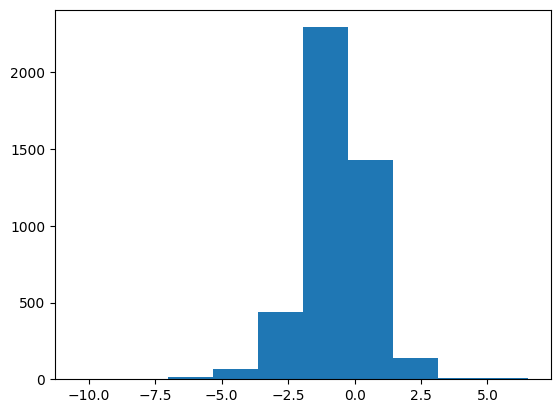

In [488]:
plt.hist((pp-pt)[:,0])

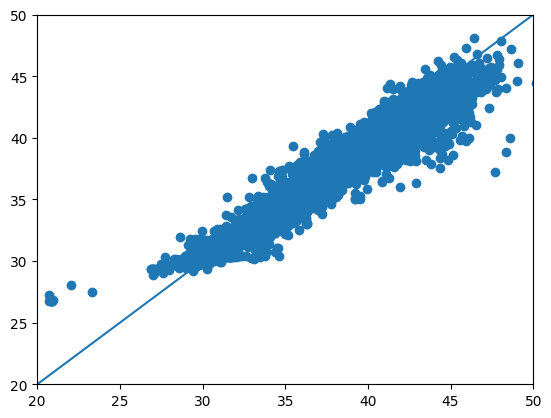

In [489]:
plt.scatter(pt[:,0], pp[:,0])
plt.xlim(20,50)
plt.ylim(20,50)
plt.plot([20,50],[20,50])

In [490]:
np.abs(pt[:,0] - pp[:,0]).mean()

1.0561227919240166

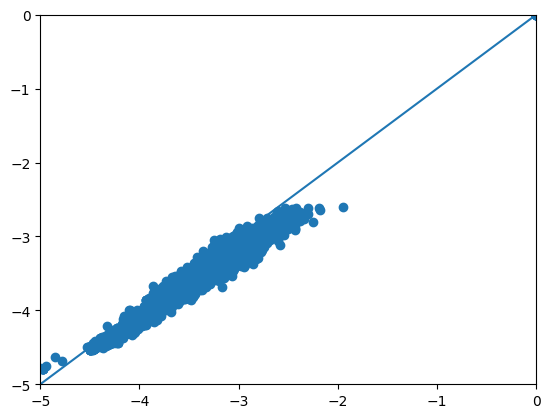

In [491]:
plt.scatter(pt[:,1], pp[:,1])
plt.xlim(-5,0)
plt.ylim(-5,0)
plt.plot([-5,0],[-5,0])

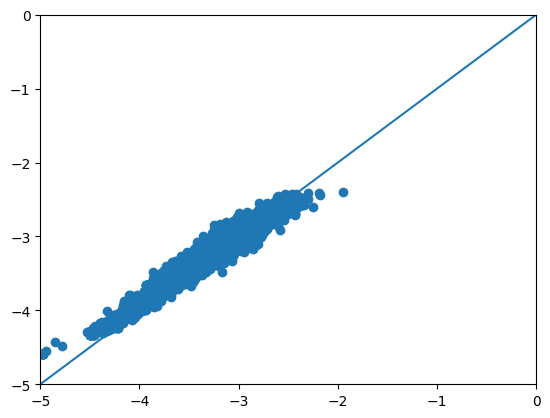

In [492]:
plt.scatter(pt[:,1], pp[:,1]+0.2)
plt.xlim(-5,0)
plt.ylim(-5,0)
plt.plot([-5,0],[-5,0])

In [493]:
np.abs(pt[:,1] - (pp[:,1]+0.2)).mean()

0.08831699190623662

(array([1.000e+00, 9.000e+00, 3.500e+01, 2.120e+02, 6.450e+02, 1.558e+03,
        1.369e+03, 4.610e+02, 9.800e+01, 1.700e+01]),
 array([-0.64287421, -0.55732531, -0.4717764 , -0.3862275 , -0.30067859,
        -0.21512969, -0.12958079, -0.04403188,  0.04151702,  0.12706593,
         0.21261483]),
 <BarContainer object of 10 artists>)

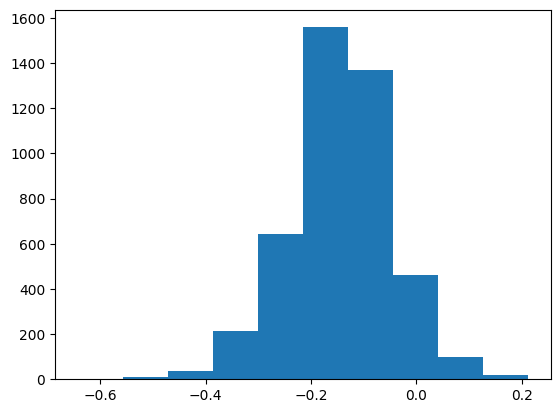

In [494]:
plt.hist((pp-pt)[:,1])

In [495]:
iso_err = np.abs(ip - it)


In [496]:
np.mean(iso_err)

0.05128267514279175

(array([3.170e+02, 1.517e+03, 1.538e+03, 7.090e+02, 2.380e+02, 6.200e+01,
        1.900e+01, 4.000e+00, 0.000e+00, 1.000e+00]),
 array([0.        , 0.02188653, 0.04377306, 0.06565959, 0.08754612,
        0.10943266, 0.13131919, 0.15320572, 0.17509225, 0.19697878,
        0.21886531]),
 <BarContainer object of 10 artists>)

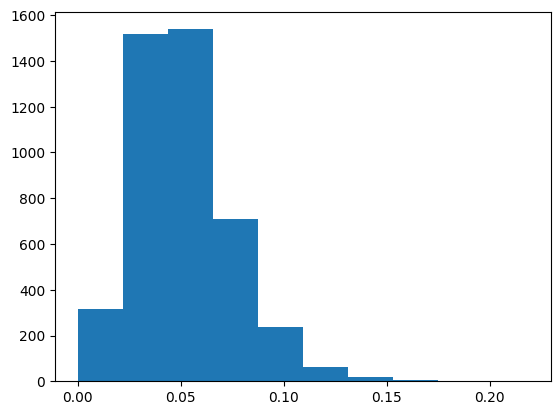

In [497]:
plt.hist(iso_err.mean(1))

In [498]:
iso_err.shape

(4405, 121)

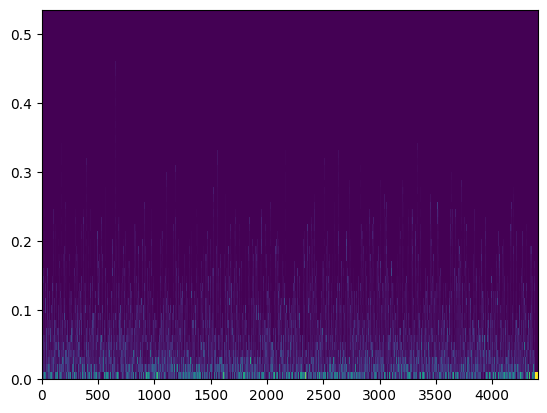

In [499]:
n = iso_err.shape[0]
x = np.repeat(np.arange(n), iso_err.shape[1])
y = iso_err.flatten()

plt.hist2d(x, y, bins=(n,50));

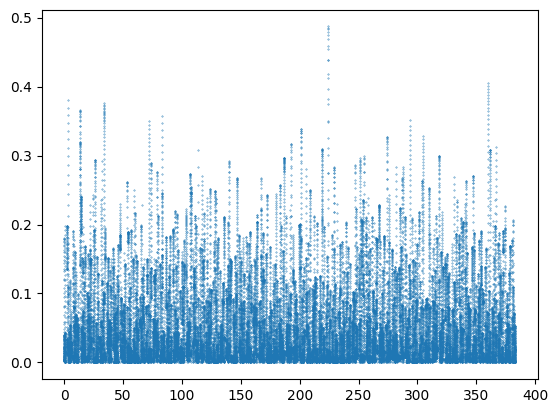

In [451]:
plt.scatter(x,y, s=0.1)

In [413]:
iso_err.mean(0)

array([0.00799069, 0.00805162, 0.00817983, 0.00835523, 0.00858905,
       0.00886776, 0.00918039, 0.00951812, 0.00987792, 0.01026356,
       0.01067597, 0.01112731, 0.0115962 , 0.01208735, 0.01261182,
       0.01317176, 0.01377016, 0.01441117, 0.01507989, 0.01577835,
       0.01651678, 0.01728846, 0.0181252 , 0.01900698, 0.01997359,
       0.02104346, 0.0221538 , 0.02333956, 0.02462142, 0.0259244 ,
       0.02725663, 0.02859228, 0.02991812, 0.03127235, 0.03274323,
       0.03424317, 0.03582268, 0.03758913, 0.03938012, 0.04110835,
       0.04289859, 0.04481366, 0.0465098 , 0.04788391, 0.04901174,
       0.04998015, 0.05082417, 0.05150297, 0.05206032, 0.05255958,
       0.05299709, 0.05335162, 0.05376049, 0.05421505, 0.05457141,
       0.05480017, 0.05507176, 0.05533013, 0.05549831, 0.05574607,
       0.05607729, 0.05648259, 0.05692099, 0.05748264, 0.05807529,
       0.05874791, 0.05957405, 0.06044535, 0.06131444, 0.06207032,
       0.06278199, 0.06346495, 0.0642982 , 0.06515113, 0.06602

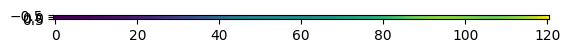

In [412]:
plt.imshow(iso_err.mean(0,keepdims=True))

In [390]:
plt.hist2d(x=get_pred_points(20), y=

TypeError: hist2d() missing 2 required positional arguments: 'x' and 'y'

In [ ]:
plt.hist((pp-pt)[:,0])